In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -U git+https://github.com/huggingface/transformers


In [ ]:
!pip install qwen-vl-utils

In [ ]:
!pip install bitsandbytes

In [ ]:
!pip install accelerate

In [ ]:
!pip install optimum

In [ ]:
!pip install auto-gptq

In [ ]:
!pip install sentencepiece

In [ ]:
pip install -U git+https://github.com/huggingface/transformers

In [ ]:
# pip install flash-attn


In [ ]:
# pip install -U git+https://github.com/Dao-AILab/flash-attention.git


In [1]:
import pandas as pd
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Load the model and processor
model_name = "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_name, 
   torch_dtype=torch.bfloat16, device_map="auto")
min_pixels = 256*28*28
max_pixels = 1280*28*28
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4", min_pixels=min_pixels, max_pixels=max_pixels)

# Define the units as per constants.py
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'maximum_weight_recommendation': {'gram', 'kilogram', 'microgram', 'milligram', 'ounce', 'pound', 'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre', 'cubic foot', 'cubic inch', 'cup', 'decilitre', 'fluid ounce', 'gallon', 'imperial gallon', 'litre', 'microlitre', 'millilitre', 'pint', 'quart'}
}

# Load the test.csv file
test_data = pd.read_csv("/kaggle/input/test-data/test_amazon.csv")





Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4732: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

3.75 inch


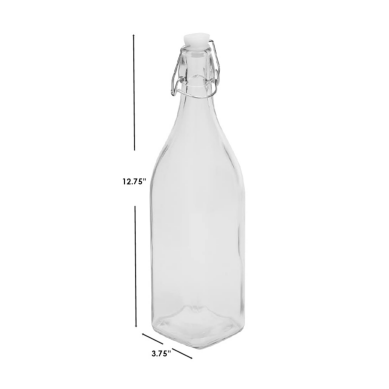

70 centimetre


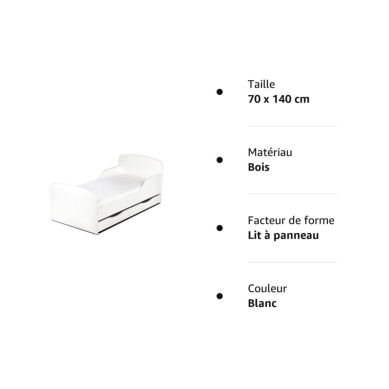

70 centimetre


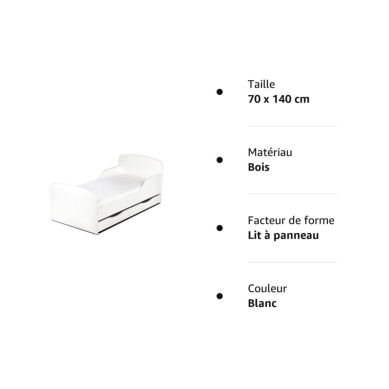

6 centimetre


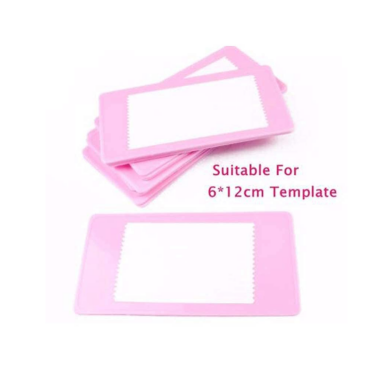

40 centimetre


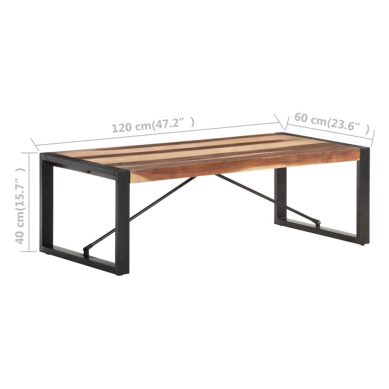

120 centimetre


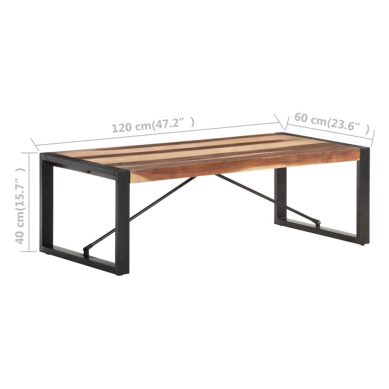

1.35 volt


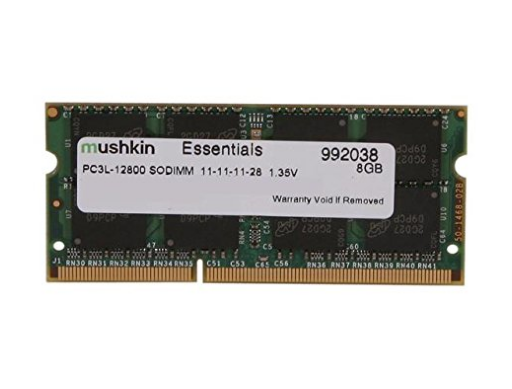

'1600 watt'


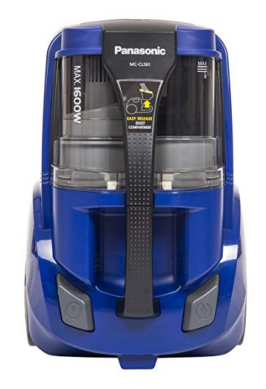

1600 watt


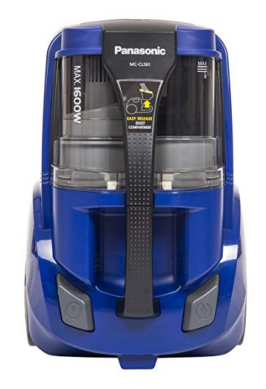

10.5 volt


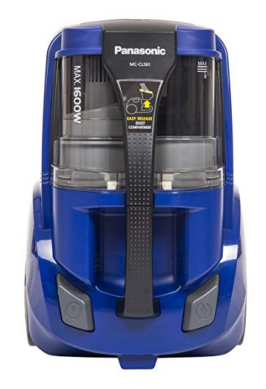

9 centimetre


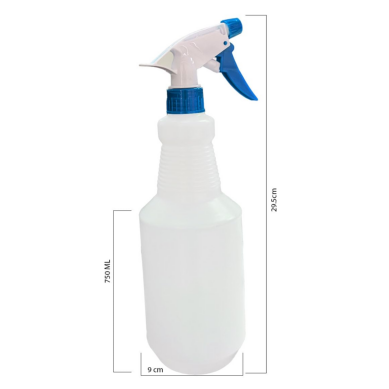

In [ ]:
import requests
# Prepare to store the predictions
predictions = []

# Specify the start and end indices for 100 rows
start_index = 1431  # You can change this to where you want to start
end_index = start_index + 300
# Iterate through each row of test data
for idx, row in test_data.iloc[start_index:end_index].iterrows():
    image_url = row['image_link']
    entity_name = row['entity_name']
    
    # Create a message prompt using the entity_name
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image_url},
            {"type": "text", "text": f"""Please analyze the product image provided and extract the *{entity_name}* of the product based on any visible text, labels, or markings. Your response should follow these guidelines:

1. *Answer Format*:
   - Provide your answer strictly in the format: *'value unit'*
     - *value*: A numerical measurement (float number) in standard decimal notation (e.g., 10.5).
     - *unit: One of the **allowed units* for *{entity_name}*, listed below.
   - *Example*: 10.5 {list(entity_unit_map[entity_name])[0]}

2. *Allowed Units for {entity_name}*:
   - {', '.join(sorted(entity_unit_map[entity_name]))}

3. *Instructions*:
   - Use only the units specified above; do *not* use any other units.
   - *Do not* include any additional text, symbols, or punctuation.
   - *Do not* perform any calculations or unit conversions; provide the value exactly as it appears in the image, using the full unit name from the allowed units.
   - If the unit in the image is abbreviated (e.g., 'kg' for 'kilogram'), convert it to the full unit name.
   - If multiple values are present, choose the one that most accurately represents the *{entity_name}*.
   - If a range is given (e.g., '8-12'), select a value within that range, preferably the midpoint.
   - If you cannot find the *{entity_name}* in the image, return an empty string: ''

4. *Examples*:

   - *Item Weight*:
     - Image text: "Net Weight: 500g"
     - Answer: 500 gram

   - *Height*:
     - Image text: "Height: 1.5 m"
     - Answer: 1.5 metre

   - *Voltage*:
     - Image text: "Voltage: 10.5V"
     - Answer: 10.5 volt

   - *Item Entity with Range*:
     - Image text: "Item Volume: 8-12 fl oz"
     - Answer: 10.0 fluid ounce (midpoint of the range)

   - *No Information Available*:
     - Image text: No relevant information
     - Answer: ''

*Please provide only the *{entity_name}* in the specified format without any additional commentary.*"""}
        ],
    }]
    
    # Prepare inputs for the model
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(text=[text], images=image_inputs, videos=video_inputs, padding=True, return_tensors="pt")
    inputs = inputs.to("cuda")
    
    # Generate the output
    generated_ids = model.generate(**inputs, max_new_tokens=28)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    # Post-process to ensure the output is in the allowed units
    predicted_value = output_text[0]
    print(predicted_value)
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    allowed_units = entity_unit_map.get(entity_name, set())
    
    # Split the prediction into value and unit and validate the unit
    if any(unit in predicted_value for unit in allowed_units):
        predictions.append({"index": row['index'], "prediction": predicted_value})
    else:
        predictions.append({"index": row['index'], "prediction": ""})

In [ ]:
# Create the submission DataFrame
submission_df = pd.DataFrame(predictions)


In [ ]:

# Save the submission file
submission_df.to_csv("submission.csv", index=False)
print("Submission file generated successfully!")

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
import gc

gc.collect()

In [ ]:
# from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
# from qwen_vl_utils import process_vision_info

# # default: Load the model on the available device(s)
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4", torch_dtype="auto", device_map="auto"
# )

# # We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# # model = Qwen2VLForConditionalGeneration.from_pretrained(
# #     "Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4",
# #     torch_dtype=torch.bfloat16,
# #     attn_implementation="flash_attention_2",
# #     device_map="auto",
# # )

# # default processer
# # processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4")

# # The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct-GPTQ-Int4", min_pixels=min_pixels, max_pixels=max_pixels)

# messages = [
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "https://m.media-amazon.com/images/I/71CE2IDHBhL.jpg",
#             },
#             {"type": "text", "text": "Extract only voltage from the image strictly"},
#         ],
#     }
# ]

# # Preparation for inference
# text = processor.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )
# image_inputs, video_inputs = process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     padding=True,
#     return_tensors="pt",
# )
# inputs = inputs.to("cuda")

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)


In [ ]:

# messages = [
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "image",
#                 "image": "https://m.media-amazon.com/images/I/71CE2IDHBhL.jpg",
#             },
#             {"type": "text", "text": "Extract only voltage from the image strictly"},
#         ],
#     }
# ]

# # Preparation for inference
# text = processor.apply_chat_template(
#     messages, tokenize=False, add_generation_prompt=True
# )
# image_inputs, video_inputs = process_vision_info(messages)
# inputs = processor(
#     text=[text],
#     images=image_inputs,
#     videos=video_inputs,
#     padding=True,
#     return_tensors="pt",
# )
# inputs = inputs.to("cuda")

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text)